# Importing libraries

In [1]:
from PIL import Image
import matplotlib.pyplot as plt
import torch
import torchvision.transforms as T
import torchvision
import numpy as np
import cv2
import os
import subprocess
import requests
import glob

In [2]:
np.random.seed(42)

In [3]:
def download_file(url, file):
    if not os.path.exists(file):
        subprocess.run(['wget',url,'-O',file,'-q'])

In [4]:
inference_dir = 'inference_data'
os.makedirs(inference_dir, exist_ok=True)

# model

In [5]:
# get the pretrained model from torchvision.models
# Note: pretrained=True will get the pretrained weights for the model.
# model.eval() to use the model for inference
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(
    weights=torchvision.models.detection.FasterRCNN_ResNet50_FPN_Weights.DEFAULT
)
model.eval()

# Class labels from official PyTorch documentation for the pretrained model
# Note that there are some N/A's
# for complete list check https://tech.amikelive.com/node-718/what-object-categories-labels-are-in-coco-dataset/
# we will use the same list for this notebook

COCO_INSTANCE_CATEGORY_NAMES = [
    '__background__', 'person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus',
    'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'N/A', 'stop sign',
    'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow',
    'elephant', 'bear', 'zebra', 'giraffe', 'N/A', 'backpack', 'umbrella', 'N/A', 'N/A',
    'handbag', 'tie', 'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball',
    'kite', 'baseball bat', 'baseball glove', 'skateboard', 'surfboard', 'tennis racket',
    'bottle', 'N/A', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl',
    'banana', 'apple', 'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza',
    'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed', 'N/A', 'dining table',
    'N/A', 'N/A', 'toilet', 'N/A', 'tv', 'laptop', 'mouse', 'remote', 'keyboard', 'cell phone',
    'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'N/A', 'book',
    'clock', 'vase', 'scissors', 'teddy bear', 'hair drier', 'toothbrush'
]

COLORS = np.random.uniform(0, 255, size=(len(COCO_INSTANCE_CATEGORY_NAMES), 3))

Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth


100%|██████████| 160M/160M [00:00<00:00, 205MB/s]


# prediction and object detection functions

In [6]:
def get_prediction(img_path, threshold):
    """
    Perform a forward pass through the model to make predictions.

    Parameters:
        img_path (str): Path to the input image.
        threshold (float): Minimum confidence score for filtering predictions.

    Returns:
        pred_boxes (list of tuples): Bounding box coordinates in the format [((x1, y1), (x2, y2)), ...].
        pred_class (list of str): Predicted class names for each bounding box.
    """

    # open the image and ensure it's RGB
    img = Image.open(img_path).convert("RGB")

    # convert to tensor
    transform = T.Compose([T.ToTensor()])
    img_tensor = transform(img)

    # forward pass - model expects a list of tensors
    pred = model([img_tensor]) # Wrapped img_tensor in a list

    # extract and detach from graph
    pred_data = pred[0]

    labels = pred_data['labels'].detach().cpu().numpy()
    boxes = pred_data['boxes'].detach().cpu().numpy()
    scores = pred_data['scores'].detach().cpu().numpy() # Corrected typo from sccores to scores

    # filter predictions based on threshold
    valid_indices = scores > threshold # Renamed `valid` to `valid_indices`

    # Format bounding boxes as a list of tuples of tuples: [((x1, y1), (x2, y2)), ...]
    pred_boxes = [((b[0], b[1]), (b[2], b[3])) for b in boxes[valid_indices]]
    pred_class = [COCO_INSTANCE_CATEGORY_NAMES[l] for l in labels[valid_indices]]

    return pred_boxes, pred_class

In [7]:
def object_detection_api(img_path,threshold=0.5):
    """
    Annotates the image with bounding boxes and class names.
    It calls the `get_prediction` function as well.
    parameters:
        img_path: path of the input image
        threshold: threshold value for prediction score
    method:
      - prediction is obtained from get_prediction method
      - for each prediction, bounding box is drawn and text is written
        with opencv
      - the final image is displayed
    """

    # get predictions
    boxes, pred_classes = get_prediction(img_path, threshold)

    # read image
    img = cv2.imread(img_path)

    # convert to RGB
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # draw boxes and add labels
    rect = max(round(sum(img.shape) / 2 * 0.003), 2)
    text = max(rect-1, 1)

    # detect object
    for i in range(len(boxes)):

        p1, p2 = (int(boxes[i][0][0]), int(boxes[i][0][1])), (int(boxes[i][1][0]), int(boxes[i][1][1]))
        color = COLORS[COCO_INSTANCE_CATEGORY_NAMES.index(pred_classes[i])]
        cv2.rectangle(img, p1, p2, color, rect) # images, top left, bottom right, color, rectangle box thickness
        (w , h), baseline = cv2.getTextSize(pred_classes[i], 0, fontScale = rect/3, thickness = text)

        # label
        outside = p1[1] - h >= 3
        p2 = p1[0]+w, p1[1] -h - 3 if outside else p1[1] + h + 3

        # draw box for label
        cv2.rectangle(img, p1, p2, color, -1, cv2.LINE_AA)

        # write label text
        cv2.putText(img, pred_classes[i], (p1[0], p1[1] - 5 if outside else p1[1] + h + 2), cv2.FONT_HERSHEY_SIMPLEX, rect/3, (255,255,255), text + 1)

    # display
    plt.figure(figsize=(15,12))
    plt.imshow(img)
    plt.xticks([])
    plt.yticks([])
    plt.show()

# Detection

## person

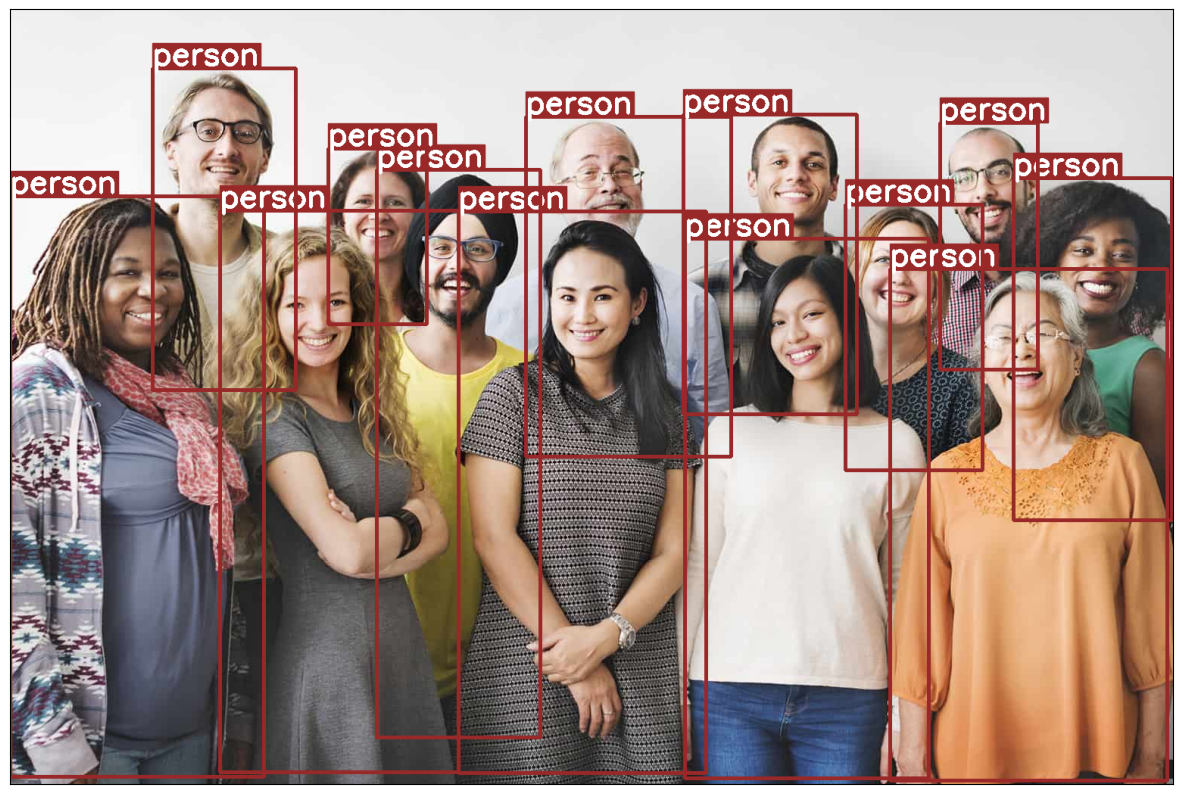

In [8]:
download_file(
    'https://learnopencv.com/wp-content/uploads/2022/10/people.jpg',
    os.path.join(inference_dir, 'people.jpg')
)
object_detection_api(os.path.join(inference_dir, 'people.jpg'), threshold=0.8)

## vehicle

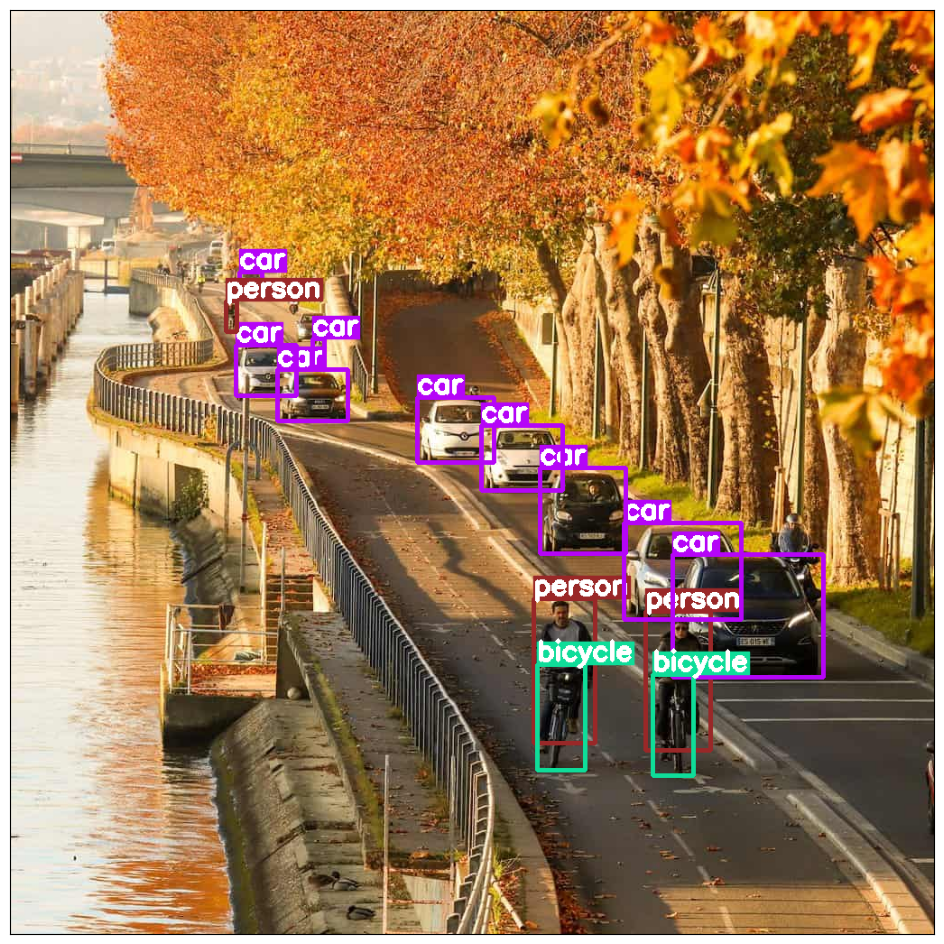

In [9]:
download_file(
    'https://learnopencv.com/wp-content/uploads/2022/10/vehicles.jpg',
    os.path.join(inference_dir, 'vehicles.jpg')
)

object_detection_api(os.path.join(inference_dir, 'vehicles.jpg'), threshold=0.8)

## traffic

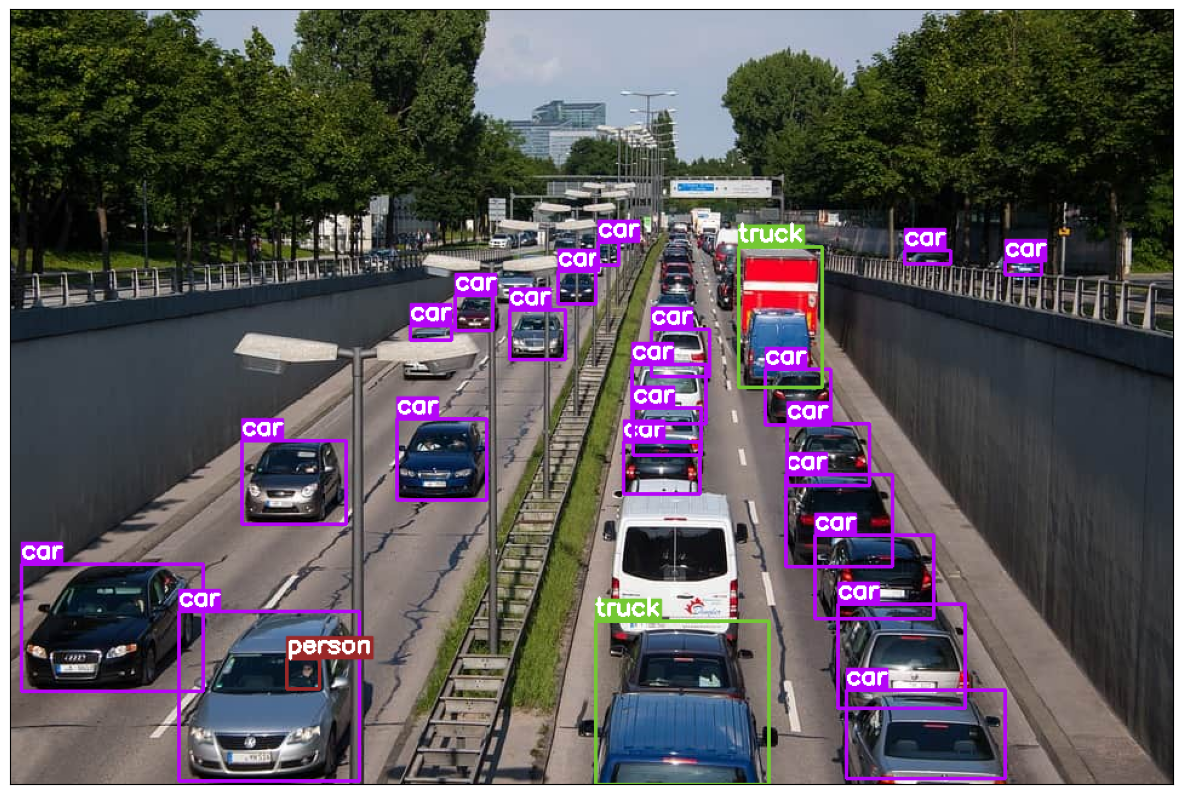

In [10]:
download_file(
    'https://learnopencv.com/wp-content/uploads/2022/10/traffic_scene.jpg',
    os.path.join(inference_dir, 'traffic_scene.jpg')
)

object_detection_api(os.path.join(inference_dir, 'traffic_scene.jpg'), threshold=0.8)

## low lighting

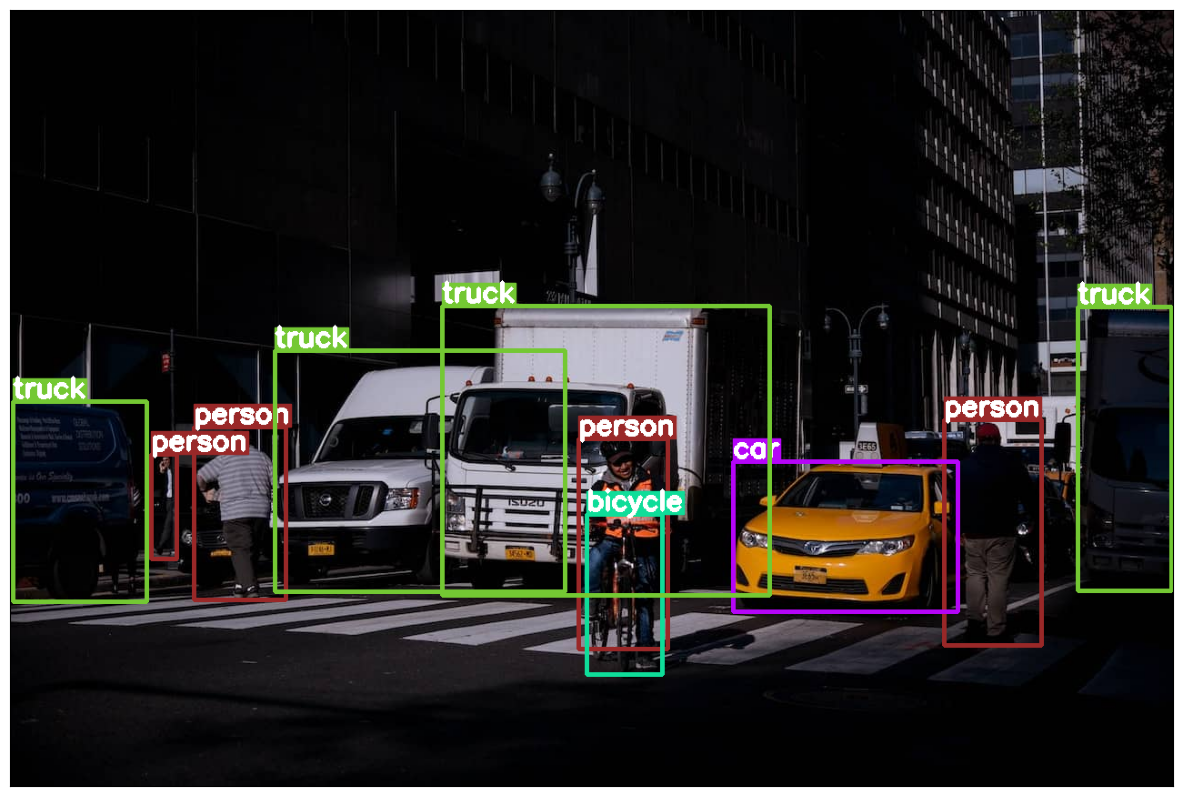

In [11]:
download_file(
    'https://learnopencv.com/wp-content/uploads/2022/10/night-time.jpg',
    os.path.join(inference_dir, 'night-time.jpg')
)

object_detection_api(os.path.join(inference_dir, 'night-time.jpg'), threshold=0.8)

## crowd

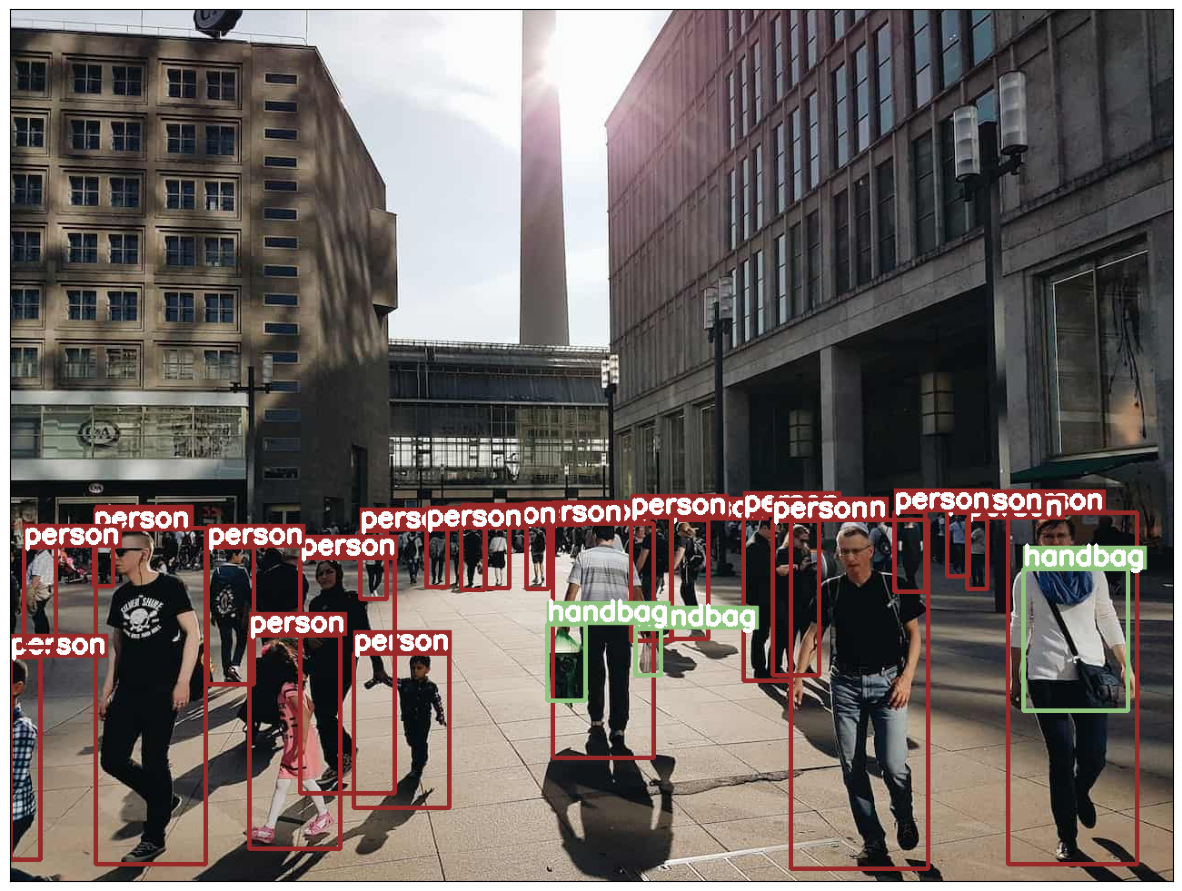

In [12]:
download_file(
    'https://learnopencv.com/wp-content/uploads/2022/10/crowd.jpg',
    os.path.join(inference_dir, 'crowd.jpg')
)

object_detection_api(os.path.join(inference_dir, 'crowd.jpg'), threshold=0.8)

# Comparison

In [13]:
import time

model = torchvision.models.detection.fasterrcnn_resnet50_fpn(
    weights=torchvision.models.detection.FasterRCNN_ResNet50_FPN_Weights.DEFAULT
)
model.eval()

def check_inference_time(image_path, device):
    """
    Measures the inference time of the Faster R-CNN model on a given image.

    Parameters:
        image_path (str): Path to the input image.
        gpu (bool): Whether to run inference on GPU (default: False).

    Returns:
        float: Time taken (in seconds) for model inference.
    """

    img = Image.open(image_path)
    transform = T.Compose([T.ToTensor()])
    img = transform(img)

    if device.type == 'cuda':
        torch.cuda.synchronize()

    with torch.inference_mode():
        start = time.time()
        _ = model([img])
        if device.type == 'cuda':
            torch.cuda.synchronize()
        end = time.time()

    return end - start

In [18]:
# Let's run inference on all the downloaded images and average their inference time
img_paths = [
    path for path in glob.glob(os.path.join(inference_dir, '*')) \
    if path.split('.')[-1].lower() in ["jpeg", "jpg", "png"]
]

cpu_device = torch.device('cpu')
gpu_device = torch.device('cuda')

print(img_paths)
gpu_time = sum(
    [check_inference_time(img_path, gpu_device) \
     for img_path in img_paths])/len(img_paths
)
cpu_time = sum(
    [check_inference_time(img_path, cpu_device) \
     for img_path in img_paths])/len(img_paths
)


print(f"Average inference time on GPU: {gpu_time:.2f} seconds")
print(f"Average inference time on CPU: {cpu_time:.2f} seconds")

['inference_data/traffic_scene.jpg', 'inference_data/crowd.jpg', 'inference_data/people.jpg', 'inference_data/vehicles.jpg', 'inference_data/night-time.jpg']
Average inference time on GPU: 4.75 seconds
Average inference time on CPU: 4.92 seconds
